# EDITO ARMS dataset

## Install packages

In [4]:
packages = ["contextily",
            "pandas",
            "geopandas",
            "matplotlib",
            "pyarrow",
            "pystac_client"]
for package in packages:
    !pip install {package} > /dev/null 2>&1
for package in packages:
    exec(f'import {package}')

In [5]:
import pyarrow.parquet as pq
import pyarrow.fs
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow.fs
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import pystac_client

## Connect to the EDITO Eurobis Occurrence data

In [6]:
occurrence_data = "https://s3.waw3-1.cloudferro.com/emodnet/emodnet_biology/12639/eurobis_obisenv_view_2025-03-20.parquet"

from urllib.parse import urlparse
parsed_url = urlparse(occurrence_data)
host = parsed_url.hostname
bucket_name = parsed_url.path.split('/')[1]
key = '/'.join(parsed_url.path.split('/')[2:])

In [7]:
s3 = pyarrow.fs.S3FileSystem(endpoint_override=host, anonymous=True)
s3_path = f"{bucket_name}/{key}"

#### Print schema of parquet dataset

In [20]:
dataset = ds.dataset(s3_path, filesystem=s3, format="parquet")
print(dataset.schema)

id: int64
datelastmodified: timestamp[us, tz=UTC]
datasetid: int32
institutioncode: string
collectioncode: string
eventid: string
observationdate: timestamp[us, tz=UTC]
season: string
yearcollected: int16
startyearcollected: int16
endyearcollected: int16
monthcollected: int16
startmonthcollected: int16
endmonthcollected: int16
daycollected: int16
startdaycollected: int16
enddaycollected: int16
timeofday: double
starttimeofday: double
endtimeofday: double
timezone: string
continentocean: string
country: string
stateprovince: string
county: string
collectornumber: string
fieldnumber: string
longitude: double
startlongitude: double
endlongitude: double
latitude: double
startlatitude: double
endlatitude: double
coordinateprecision: double
verbatimpositiondetail: string
minimumdepth: double
maximumdepth: double
occurrenceid: string
scientificname: string
aphiaid: int32
taxonrank: int16
rankname: string
scientificname_accepted: string
scientificnameauthor: string
aphiaidaccepted: int32
kingd

#### Filter dataset

In [21]:
filtered_table = dataset.to_table(
    filter=(
        (pc.field("datasetid") == pc.scalar(8357)) &
        (pc.field("latitude") >= 51) &
        (pc.field("latitude") <= 51.5) &
        (pc.field("longitude") >= 2.5) &
        (pc.field("longitude") <= 3.3)
   
    ),
    columns=["datasetid", "latitude", "longitude", "parameter", "parameter_value", "aphiaidaccepted"]
)

## Load table as dataframe

In [22]:
df = filtered_table.to_pandas()

#### Inspect the data

In [23]:
df

,datasetid,latitude,longitude,parameter,parameter_value,aphiaidaccepted
0,8357,51.364298,3.20701,Duration (s),13910400,854806.0
1,8357,51.364298,3.20701,SamplPreservation (Dmnless),DMSO,854806.0
2,8357,51.364298,3.20701,Duration (s),13910400,NaN
3,8357,51.364298,3.20701,SamplPreservation (Dmnless),DMSO,NaN
4,8357,51.364298,3.20701,Duration (s),13910400,157933.0
...,...,...,...,...,...,...
235,8357,51.364298,3.20701,SamplPreservation (Dmnless),DMSO,375734.0
236,8357,51.364298,3.20701,Duration (s),13910400,149075.0
237,8357,51.364298,3.20701,SamplPreservation (Dmnless),DMSO,149075.0
238,8357,51.364298,3.20701,Duration (s),13910400,141579.0


## Plot on a map

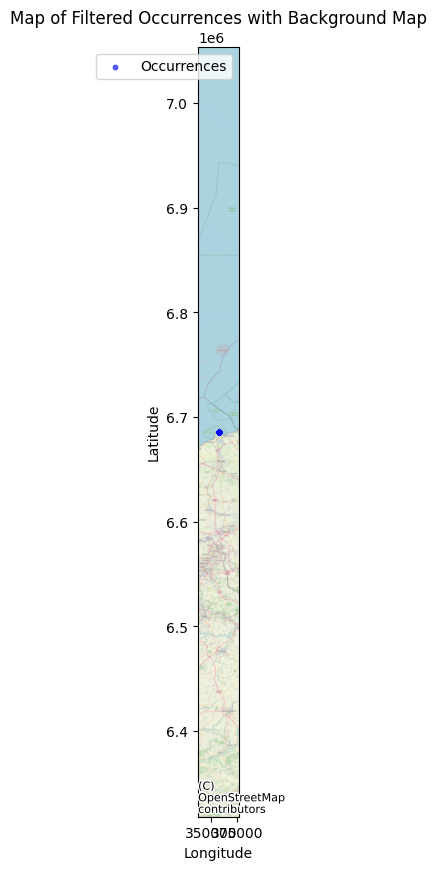

In [24]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"  # WGS84 coordinate system
)
fig, ax = plt.subplots(figsize=(10, 10))
gdf = gdf.to_crs(epsg=3857)  # Reproject to Web Mercator for compatibility with contextily
gdf.plot(ax=ax, color="blue", markersize=10, alpha=0.6, label="Occurrences")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)
ax.set_title("Map of Filtered Occurrences with Background Map")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.legend()
plt.show()